In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Poisson Processes

The processes we have just discussed are continuous time, continuous state.  (Moreover, they have continuous sample paths with probability 1, but that is substantially more difficult to prove.)  There are also many important continuous time, discrete state processes.  One of the most important is the Poisson process.  We say that $\{N_t\}$ is a Poisson process with parameter $\lambda > 0$ if it has the following properties:

1) It is a Markov process.

2) Each $N_t$ takes values in $\mathbb{N} = \{0, 1, 2, \dotsc\}$.  (Such processes are known as *counting processes*.)

3) if $t > s \geq 0$ then $N_t - N_s\sim \textrm{Poisson}(\lambda(t - s))$

Typically, we choose $N_0 = 0$ with probability 1.  In this case, for any $t > 0$ we have

$$P(N_t = n) = e^{-\lambda t}\frac{(\lambda t)^n}{n!}$$

This is a *jump process* because $N_t$ will jump from one value to another.  That is, if we plot a sample path of $N_t$ as a function of time, then it will typically have jump discontinuities.  It is often useful to know the distribution of the times at which these jump discontinuities appear (i.e., the *jump times*).

To start, suppose $N_0 = 0$ and define the first jump time as

$$\tau_1 = \inf\left\{ t > 0 \:\vert\: N_t > 0\right\}$$

We have

$$\begin{aligned}
\mathbb{P}\left[\tau \leq t\right] &= 1 - \mathbb{P}\left[\tau > t\right] \\
&= 1 - \mathbb{P}\left[N_t = 0\right] \\
&= 1 - e^{-\lambda t}
\end{aligned}$$

This is the cdf of an exponential random variable, and so we have

$$\tau_1 \sim \textrm{Exp}(\lambda)$$

If we define the later jump times by

$$\tau_{k + 1} = \inf\left\{ t > 0 \:\vert\: N_t > k\right\}$$

then we can use the same logic to show that

$$\tau_{k + 1} - \tau_k\sim \textrm{Exp}(\lambda)$$

Because the Poisson process is Markovian, we the inter-jump times $\tau_{k + 1} - \tau_k$ must also be independent.  This means that, given $N_t = n$, the time $\tau$ until the next jump is always exponentially distributed with paramter $\lambda$ and independent of $N_s$ for all $s < t$.

## Simulating a Poisson process

We can simulate a Poisson process by just simulating the jump times.  In particular, we have the following algorithm:

1) Set $k = 0$, $t_0 = 0$ and generate $N_0$.  (Typically $N_0$ is just zero, but it's perfectly fine to generate from some known distribution.)

2) Generate the time until the next jump $\tau\sim \textrm{Exp}(\lambda)$

3) Set $t_{k + 1} = t_{k} + \tau$, set $N_{k + 1} = N_{k} + 1$ and set $k = k + 1$.  Go back to step 2.

Notice that this is the same method as we used to simulate a discrete time process, but we are choosing the times $t_k$ as we go.

There are two standard ways to choose when to stop.  You can either pick a fixed number of steps (so that you stop when $N_t = n$ for some fixed $n > 0$) or you can pick a fixed final time (so that you stop when $t_k \geq T$.

### Simulate a Poisson process with $N_0 = 0$ and rate $\lambda = 2$.

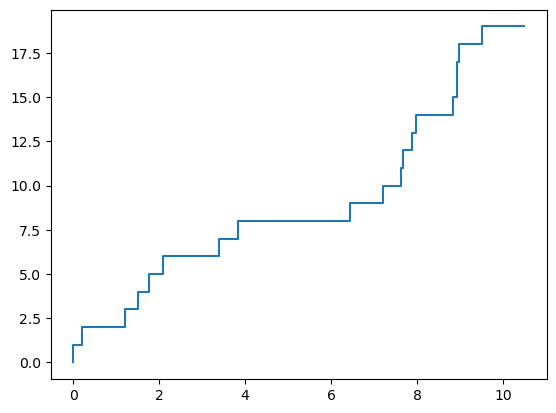

In [4]:
lam = 2
T = 10

k = 0
current_time = 0
t = np.array([current_time])
N = 0

while current_time < T:
    u = np.random.uniform(0, 1)
    current_time = current_time - np.log(u) / lam
    N += 1
    t = np.append(t, current_time)

n = np.arange(N + 1)
plt.step(t, n)
plt.show()

## Inhomogeneous Poisson processes

The Poisson process we described above is time homogeneous, because the distribution of jump times does not depend on the current time $t$.  In practice, this is often not a reasonable assumption.  The simplest generalization is to assume that the rate $\lambda$ is not constant, but instead a deterministic, non-negative function of time $\lambda(t)$.

We define such a process by assuming that

$$\mathbb{P}\left[N(t + \Delta t) - N(t) = n + 1 \:\vert\: N(t) = n\right] = \lambda(t)\Delta t + o(\Delta t)$$

and

$$\mathbb{P}\left[N(t + \Delta t) - N(t) > n + 1 \:\vert\: N(t) = n\right] = o(\Delta t)$$

In other words, over a sufficiently small time-span $\Delta t$, the process has one jump with probability $\approx \lambda(t)\Delta t$, zero jumps with probability $\approx 1 - \lambda(t)\Delta t$ and more than one jump with probability $\approx$.

One can show that, for fixed $t$ and $s$ with $0 \leq s < t$, the increment $N_{t} - N_{s}$ has a Poisson distribution with rate

$$\Lambda = \int_{s}^{t}\lambda(u)\,\textrm{d}u$$

Assuming we can integrate $\Lambda$, we can use this property to simulate $N_t$ at fixed times (essentially the same as the $\tau$-leaping described above).

If we want to simulate at the jump times, then - in principle - we can use $\Lambda$ to determine the distribution of jump times and then simulate these jumps with the inverse transform method.  In practice, actually evaluating the cdf for these jump times, let alone its inverse, is usually not practical.  A common alternative is known as *thinning*.

## Thinning

The thinning approac relies on the following key fact about Poisson processes.  If $N_t$ and $M_t$ are independent poisson processes with rates $\lambda_1(t)$ and $\lambda_2(t)$, then $N_t + M_t$ is also a Poisson process with rate $\lambda_1(t) + \lambda_2(t)$.  Moreover, given that a jump occurs at time $\tau$, the process $N_t$ has a jump at time $\tau$ with probability $\lambda_1(t)/(\lambda_1(t) + \lambda_2(t))$ and the process $M_t$ has a jump with probability $\lambda_2(t)/(\lambda_1(t) + \lambda_2(t))$.  That is, the probability that a jump "belongs to" $N_t$ is proportional to its rate.

We will construct an extra process $M_t$ in such a way that $N_t + M_t$ is easy to simulate, then discard all of the jumps that correspond to $M_t$.  This is an analog of acceptance-rejection for processes.

Consider an inhomogeneous Poisson process $N_t$ with rate $\lambda(t)$ and suppose that there is some constant $\overline{\lambda}$ such that $\lambda(t) \leq \overline{\lambda}$ for all $t$.  We will define $M_t$ as a Poisson process with rate $\overline{\lambda} - \lambda(t)$.  This means that $N_t + M_t$ is a Poisson process with *constant* rate $\overline{\lambda}$, which is easy to simulate.  We will simulate the jump times of this new compound process.  Then, for each jump time, we will accept the jump with probability $\lambda(t)/\overline{\lambda}$ and reject it with probability $1 - \lambda(t)/\overline{\lambda}$.  We get the following algorithm:

1) Set $k = 0$, $t_0 = 0$ and generate $N_0$.  (Typically $N_0$ is just zero, but it's perfectly fine to generate from some known distribution.)

2) Generate the time until the next jump $\tau\sim \textrm{Exp}(\overline{\lambda})$

3) Set $t_{k + 1} = t_{k} + \tau$.

4) Generate $U\sim U(0, 1)$. If $U \leq \lambda(t) / \overline{\lambda}$, then accept the jump and set $N_{k + 1} = N_{k} + 1$.  Otherwise, reject the jump and set $N_{k + 1} = N_{k}$.  Set $k = k + 1$ and go back to step 2.

### Simulate a Poisson process with $N_0 = 0$ and rate $\lambda(t) = 0.1 + 1.9e^{-0.1t}$.

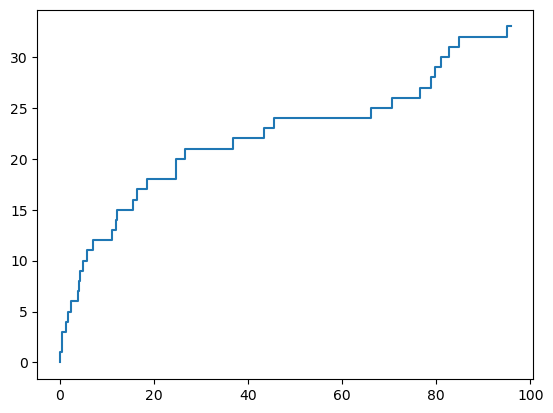

In [6]:
lam_max = 2
T = 100
current_time = 0
t = np.array([current_time])
N = 0

def lam(t):
    return 0.1 + 1.9 * np.exp(-0.1*t)

while current_time < T:
    u = np.random.uniform(0, 1, size=2)
    current_time = current_time - np.log(u[0]) / lam_max
    if u[1] <= lam(current_time) / lam_max:
        N += 1
        t = np.append(t, current_time)

n = np.arange(N + 1)
plt.step(t, n)
plt.show()

## Decay Process

The time-inhomogeneous processes that we considered above depended on $t$ through a deterministic rate function $\lambda(t)$.  However, it is common to consider situations where the rate $\lambda$ depends on the state $N_t$.  As an example, suppose we have a collection of $n_0$ atoms of some radioactive isotope.  Each will decay at some exponentially distributed time $\tau_i\sim \textrm{Exp}(\lambda)$.  We will assume that all the $\tau_i$ are mutually independent.  Let $N_t$ be the number of atoms that have not yet decayed.

We can simulate $N_t$ in a very similar manner to our previous approach: At every step, we generate the waiting time $\tau$ until the next decay, then set $t_{k+1} = t_{k} + \tau$ and set $N_t = N_t - 1$.  Generating the waiting time might seem challenging, but it is made much easier by the following fact: If $\tau_i\sim\textrm{Exp}(\lambda_i)$ are independent, then

$$\textrm{min}\left[\tau_1, \dotsc, \tau_n\right] \sim \textrm{Exp}\left(\sum_{i = 1}^{n}\lambda_i\right)$$

This means that if $N_t = n$, then the time until the decay is given by $\tau\sim\textrm{Exp}(n\lambda)$.  We therefore have the following algorithm:

1) Set $N_0 = n_0$, $t_0 = 0$ and $k = 0$.

2) Generate a waiting time $\tau\sim \textrm{Exp}(N_k\lambda)$ and set $t_{k + 1} = t_{k} + \tau$

3) Set $N_{k + 1} = N_k - 1$.

4) Set $k = k + 1$ and go back to step 2.

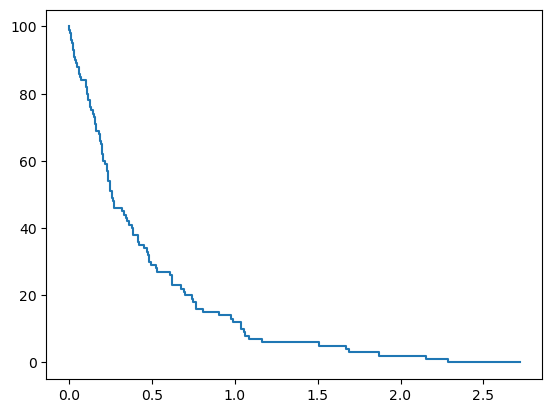

In [7]:
lam = 2
T = 10
current_time = 0
t = np.array([current_time])
N = 100
n = np.array([N])

while N > 0 and current_time < T:
    u = np.random.uniform(0, 1)
    current_time = current_time - np.log(u) / (N * lam)
    N -= 1
    n = np.append(n, N)
    t = np.append(t, current_time)

plt.step(t, n)
plt.show()

# Birth-Death Processes

As a more complicated example, consider a birth-death process where $N_t$ represents the number of molecules of a given chemical species at time $t$.  Suppose that molecules are synthesized at a constant rate $\beta$, but that they degrade at a density-dependent rate $\delta N_t$.  That is, the growth rate is constant, but the decay rate increases proportionally to the number of molecules.  This means that $N_t$ is the sum of two counting processes: One Poisson process with rate $\beta$ and another decay process with rate $\delta N_t$.  In general, these processes are not independent because the rate of the decay process very much depends on the value of the synthesis process.  However, if we know that $N_t = n$, then the waiting time for both the synthesis and decay processes are independent exponentials.  We could therefore simulate both waiting times, then accept the reaction (synthesis or decay) that happened first.  However, there is an easier approach based on the relationship between exponential random variables: If $\tau_i\sim \textrm{Exp}(\lambda_i)$ are independent, then

$$\min\left(\tau_1, \dotsc, \tau_n)\right) \sim \textrm{Exp}\left(\sum_{i = 1}^{n}\lambda_i\right)$$

and

$$\mathbb{P}\left[\min(\tau_1, \dotsc, \tau_n) = \tau_i\right] = \frac{\lambda_i}{\sum_{i = 1}^{n}\lambda_i}$$

This means that we can generate the waiting time until the next reaction (of *any* type) and then decide which reaction type it will be.  This gives us the following algorithm, known as the Gillespie algorithm:

1) Set $N_0 = n_0$, $t_0 = 0$ and $k = 0$.

2) Generate a waiting time $\tau\sim\textrm{Exp}(\beta + \delta N_k)$ and set $t_{k + 1} = t_{k} + \tau$.

3) Generate a uniform random variable $U\sim U(0, 1)$.  If $U <= \beta/(\beta + \delta N_k)$, then use a synthesis reaction and set $N_{k + 1} = N_{k} + 1$.  Otherwise, use a decay reaction and set $N_{k + 1} = N_{k} - 1$.

4) Set $k = k + 1$ and return to step (2).

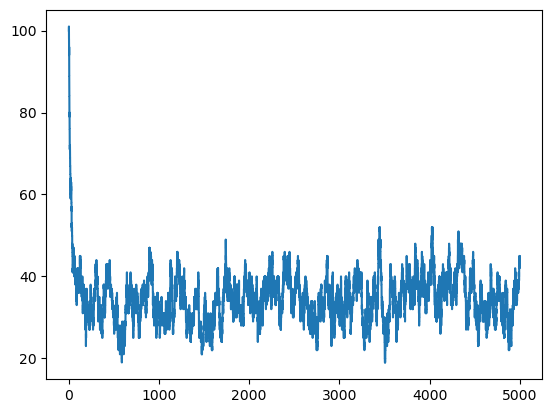

In [8]:
beta = 1
delta = 0.03
T = 5000
current_time = 0
t = np.array([current_time])
N = 100
n = np.array([N])

while N > 0 and current_time < T:
    u = np.random.uniform(0, 1, size=2)
    current_time = current_time - np.log(u[0]) / (beta + delta * N)
    if u[1] <= beta / (beta + delta * N):
        N += 1
    else:
        N -= 1
    n = np.append(n, N)
    t = np.append(t, current_time)

plt.step(t, n)
plt.show()

# Jump Diffusion

Poisson processes are the simplest version of a stochastic process with jumps, but they are not (at least on their own) the most relevant to financial applications.  Rather than directly modeling the value of an asset with something like a Poisson process or a birth-death process, we would like to incorporate jumps into an SDE.  There are a variety of ways ot do this, but the most common framework is to use an SDE of the form

$$\textrm{d}X_t = \mu(t, X_t)\,\textrm{d}t + \sigma(t, X_t)\,\textrm{d}W_t + j(t, X_t)\,\textrm{d}J_t$$

where the first two terms are defined in the same way as our previous examples and

$$J_t = \sum_{i = 1}^{N_t}\left(Y_i - 1\right)$$

with $N_t$ a Poisson process and $Y_i$ random variables.  The process $J_t$ is called a *jump process*, and $X_t$ is known as a *jump diffusion process*.  This framework is fairly general, but we will make the extra assumptions that $N_t\sim\textrm{Poisson}(\lambda)$ has a constant rate and that $N_t$ and all of the $Y_i$ are mutually independent and that the $Y_i$ are all identically distributed.

Moreover, we will work solely with the drift and volatility coefficients $\mu(t, X_t) = \mu X_t$ and $\sigma(t, X_t) = \sigma X_t$ and $j(t, X_t) = X_t$.  That is, we will look at geometric Brownian motion with jumps.  The simulation methods we use apply to more general SDEs, but the notation becomes messier.

It's worth taking a moment to explain why we chose such a strange formula for $J_t$.  To see this, let $t_1 = \tau - \Delta t/2$ and $t_2 = \tau + \Delta t/2$ for some $\tau > 0$ and $0 < \Delta t \ll 1$.  We have

$$\begin{aligned}
\left(X_{t_2} - X_{t_1}\right) &\approx \mu X_{t_1}\Delta t + \sigma X_{t_1}\sqrt{\Delta t}Z + X_{t_1}\left(J_{t_2} - J_{t_1}\right)
\end{aligned}$$

where $Z\sim N(0, 1)$.  As $\Delta t$ goes to zero, the first two terms vanish, and so the change in $X_{t}$ depends only on the jump process.  Since $N_t$ is a Poisson process, we know that when $\Delta t$ goes to zero there will be at most one jump in the interval $[t_1, t_2]$.  If there is no jump at $\tau$, then $J_{t_2} - J_{t_1} = 0$, and so $X_{t_2} - X_{t_1} \approx 0$ and the process is continuous at $t = \tau$.  If there is a jump at $\tau$, then

$$J_{t_2} - J_{t_1} = Y_k - 1$$

for some $k\in\mathbb{Z}^{+}$.  We therefore have

$$X_{t_2} - X_{t_1} \approx X_{t_1}\left(Y_k - 1\right)$$

and so

$$X_{t_2} \approx Y_k X_{t_1}$$

In other words, at the $k$th jump, the value of $X_t$ changes (with a jump discontinuity) by a factor of $Y_k$.

If we are modeling the value of an asset, then we would like $X_t$ to be non-negative for all time.  This suggests that we should choose the random variables $Y_k$ to be non-negative.  A very common choice is to make the $Y_k$ lognormally distributed.  Equivalently, we can write

$$Y_k = e^{J_k}$$

where $J_k\sim N(\mu, \sigma^2)$.

## Simulating Jump Diffusion

When simulating an SDE, we typically have a set of time points $0 = t_1 < t_2 < \cdots < t_n$ that we want to simulate $X_t$ at.  There are two common ways to incorporate jumps:

1) We can explicitly calculate the jump times $\tau_i$ in the range $[t_1, t_n]$ and add these to our array of times.  At each time-point, we increment $X_t$ as usual for an SDE.  If the time-point is a jump, then we also calculate $Y_i$ and multiply $X_t$ by that factor.

2) We do not explicitly calculate the jump times.  Instead, we generate the number of jumps in the interval $N_{t_{k+1}} - N_{t_k}\sim \textrm{Poisson}(\lambda\cdot(t_{k + 1} - t_{k}))$ and generate the magnitude of each jump and multiply by their magnitude.  This is easiest to do by first simulating $\ln X_t$.  We have

$$\ln X_{t_{k+1}} \approx \ln X_{t_k} + \left(\mu - \frac{\sigma^2}{2}\right)\Delta t + \sigma\sqrt{\Delta t}Z + \sum_{i = N(t_{k}) + 1}^{N(t_{k+1})}\ln Y_k$$

### Simulate a jump diffusion process without explicitly calculating the jump times.  Assume that $Y_k = e^{X_k}$ where $X_k\sim N(0, 1)$ and $N_t\sim\textrm{Poisson}(0.01)$

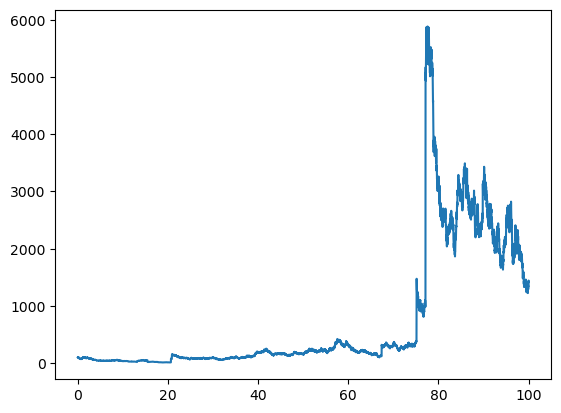

In [9]:
def generate_poisson(lam):
    n = 0
    p = np.exp(-lam)
    F = p
    u = np.random.uniform(0, 1)
    while u > F:
        p = lam * p / (n + 1)
        F += p
        n += 1
    return n

lam = 0.1
mu = 0.01
sigma = 0.2
x0 = 100

mu_jump = 0
sigma_jump = 1

T = 100
N = 10000
dt = T / N
t = np.linspace(0, T, N + 1)
log_x = np.zeros_like(t)
log_x[0] = np.log(x0)

for k in range(N):
    num_jumps = generate_poisson(lam * dt)
    z = np.random.randn(num_jumps + 1)
    log_x[k + 1] = log_x[k] + (mu - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * z[0]
    for i in range(num_jumps):
        log_x[k + 1] += mu_jump + sigma_jump * z[i + 1]

x = np.exp(log_x)
plt.plot(t, x)
plt.show()